This is part two of the Male Female NN project. I'll start with my config blocks. 

In [1]:
import keras 
import os, shutil


print(keras.__version__)

base_dir = '/home/keshav/ML_proj/working_dir/ml_working_dir/PA5/p5/programming5'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training male pictures
train_male_dir = os.path.join(train_dir, 'male')

# Directory with our training female pictures
train_female_dir = os.path.join(train_dir, 'female')

# Directory with our validation male pictures
validation_male_dir = os.path.join(validation_dir, 'male')

# Directory with our validation female pictures
validation_female_dir = os.path.join(validation_dir, 'female')

# Directory with our validation male pictures
test_male_dir = os.path.join(test_dir, 'male')

# Directory with our validation female pictures
test_female_dir = os.path.join(test_dir, 'female')

from keras.models import Sequential as SQ
from keras.applications import VGG16
from keras.layers import Conv2D as C2D, MaxPooling2D as MP2D, Flatten as F, Dropout as Drp, Dense as Dns
from keras.preprocessing.image import ImageDataGenerator as IDG
import numpy as np
import matplotlib.pyplot as plt
import dill
INPUT_DATA_SHAPE = (218, 178)
random_seed = 42
np.random.seed(random_seed)
%matplotlib inline


Using TensorFlow backend.


2.2.4


In [2]:
#Version of the build_generator function. This version does not do any data augmentation though. 
def build_generator(gen_dirs):
    return IDG().flow_from_directory(gen_dirs, 
                                      target_size=INPUT_DATA_SHAPE, 
                                      color_mode='rgb',  
                                      class_mode='binary', 
                                      batch_size=32, 
                                      shuffle=True, 
                                      seed=random_seed,
                                      interpolation='nearest')

In [3]:
train_gen = build_generator(train_dir)
val_gen = build_generator(validation_dir)
test_gen = build_generator(test_dir)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the classifier alone:

In [4]:
INPUT_SHAPE = (218, 178, 3)
conv_n = VGG16(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

In [5]:
conv_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 218, 178, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 218, 178, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 218, 178, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 109, 89, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 109, 89, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 109, 89, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 54, 44, 128)       0         
__________

This seems right! 

Next up we do fast feature extraction! Our IDG doesn't augment the data, so everything should be all set.

In [6]:
cls = SQ()
cls.add(conv_n)
cls.add(F())
cls.add(Dns(2**8, activation='relu', input_dim=(6*5*512)))
cls.add(Drp(.5))
cls.add(Dns(1, activation='sigmoid'))

In [7]:
cls.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3932416   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 18,647,361
Trainable params: 18,647,361
Non-trainable params: 0
_________________________________________________________________


In [8]:
conv_n.trainable = False

**Note: I am using the default learning rate, which is larger than what is in the book. The hope here is that as a result I will be able to do fewer steps + epochs as a result, and not have to worry too much about overfit. It probably won't be as close to the global minimum though**

In [9]:
from keras.optimizers import RMSprop
cls.compile(optimizer=RMSprop(),
                    loss="binary_crossentropy",
                    metrics=["acc"])

In [10]:
cls.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3932416   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 18,647,361
Trainable params: 3,932,673
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
hist = cls.fit_generator(train_gen, steps_per_epoch=25, epochs=50, validation_data=val_gen, validation_steps=7, workers=25, use_multiprocessing=True)

Epoch 1/50
25/25 [==============================] - 485s 19s/step - loss: 3.1111 - acc: 0.7763 - val_loss: 2.3326 - val_acc: 0.8348
Epoch 2/50
25/25 [==============================] - 491s 20s/step - loss: 3.0463 - acc: 0.8013 - val_loss: 3.8225 - val_acc: 0.7500
Epoch 3/50
25/25 [==============================] - 484s 19s/step - loss: 2.6575 - acc: 0.8212 - val_loss: 1.7247 - val_acc: 0.8839
Epoch 4/50
25/25 [==============================] - 491s 20s/step - loss: 2.1280 - acc: 0.8538 - val_loss: 2.0364 - val_acc: 0.8616
Epoch 5/50
25/25 [==============================] - 480s 19s/step - loss: 1.7478 - acc: 0.8862 - val_loss: 2.0196 - val_acc: 0.8650
Epoch 6/50
25/25 [==============================] - 484s 19s/step - loss: 1.6437 - acc: 0.8901 - val_loss: 1.4905 - val_acc: 0.9018
Epoch 7/50
25/25 [==============================] - 491s 20s/step - loss: 1.9134 - acc: 0.8700 - val_loss: 1.4295 - val_acc: 0.9018
Epoch 8/50
25/25 [==============================] - 484s 19s/step - loss: 1.

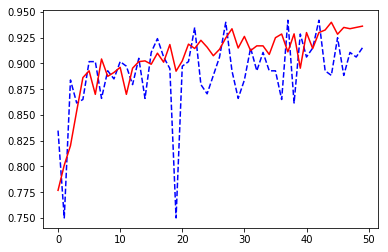

In [12]:
plt.plot(hist.history["val_acc"], 'b--')
plt.plot(hist.history["acc"], 'r-')

In [26]:
cls.save('img_model_big_base_VGG16_freezef.h5')

## Fine tune the end model

In [11]:
cls = keras.models.load_model('img_model_big_base_VGG16_freezef.h5')

In [12]:
conv_n.trainable = True
set_trainable = False
for layer in conv_n.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
from keras.optimizers import RMSprop

cls.compile(optimizer=RMSprop(lr=1e-5),#Small learning rate from book. 
                    loss="binary_crossentropy",
                    metrics=["acc"])

In [14]:
cls.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3932416   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 18,647,361
Trainable params: 11,012,097
Non-trainable params: 7,635,264
_________________________________________________________________


In [15]:
hist_2 = cls.fit_generator(train_gen, steps_per_epoch=25, epochs=4, validation_data=val_gen, validation_steps=7)

Epoch 1/4
25/25 [==============================] - 547s 22s/step - loss: 0.4486 - acc: 0.9713 - val_loss: 1.5768 - val_acc: 0.9018
Epoch 2/4
25/25 [==============================] - 537s 21s/step - loss: 0.6665 - acc: 0.9576 - val_loss: 1.8829 - val_acc: 0.8795
Epoch 3/4
25/25 [==============================] - 545s 22s/step - loss: 0.5466 - acc: 0.9650 - val_loss: 1.0218 - val_acc: 0.9241
Epoch 4/4
25/25 [==============================] - 536s 21s/step - loss: 0.5982 - acc: 0.9625 - val_loss: 1.5865 - val_acc: 0.8973


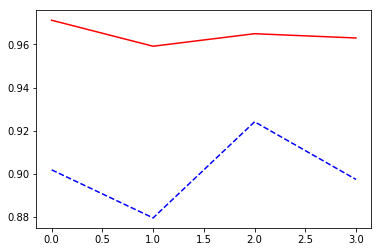

In [17]:
plt.plot(hist_2.history["val_acc"] , 'b--')
plt.plot(hist_2.history["acc"], 'r-')

In [ ]:
test_res = cls.evaluate_generator(test_gen, steps=50, max_queue_size=10,  verbose=3)

In [ ]:
print(cls.metrics_names)
print(test_res)